# Testing L
In this notebook we will test the L parameter of the omnipool spec, which is intended to help stabilize the price of LRNA by removing it from the pool over time.


## Simulation Setup

In [1]:
# Dependencies
import matplotlib.pyplot as plt
import random
import sys

sys.path.append('../..')
# Experiments
from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState
from model.amm.agents import Agent
from model.amm.trade_strategies import random_swaps, steady_swaps, invest_all, withdraw_all, sell_all, omnipool_arbitrage
from model.amm.global_state import GlobalState, fluctuate_prices

# same seed, same parameters = same simulation result
random.seed(42)

price_dict = {
    'HDX': 0.05,
    'USD': 1,
    'LRNA': 0.5,
    'R1': 6,
    'R2': 18
}

def lrna_price(asset: str):
    return price_dict['LRNA'] / price_dict[asset]

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 2000000 * lrna_price('HDX'), 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 2000000 * lrna_price('USD'), 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 2000000 * lrna_price('R1'), 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 2000000 * lrna_price('R2'), 'LRNA_price': lrna_price('R2')},
            },
            lrna_fee=0.01,
            asset_fee=0
        )
    },
    agents = {
        'Trader1': Agent(
            holdings={'R1': 1000000 * lrna_price('R1'), 'R2': 1000000 * lrna_price('R2')},
            trade_strategy=random_swaps(pool_id='omnipool', amount={'R1': 500 * lrna_price('R1'), 'R2': 500 * lrna_price('R2')})
        ), 
        'Trader2': Agent(
            holdings={'R1': 1000000 * lrna_price('R1'), 'R2': 1000000 * lrna_price('R2')},
            trade_strategy=random_swaps(pool_id='omnipool', amount={'R1': 0, 'R2': 20})
        ),
        'Arbitrageur': Agent(
            holdings={'R1': 1000000, 'R2': 1000000, 'LRNA': 1000000, 'USD': 1000000, 'HDX': 1000000},
            trade_strategy=omnipool_arbitrage(pool_id='omnipool')
        ),
        'LP1': Agent(
            holdings={'R1': 10000, 'USD': 10000},
            trade_strategy=(
                invest_all('omnipool')
                + sell_all(pool_id='omnipool', sell_asset='LRNA', buy_asset='R1')
                + withdraw_all(when=500)
                + random_swaps(pool_id='omnipool', amount={'R1': 60, 'USD': 10, 'R2': 0})
            )
        ),
        'LP2': Agent(
            holdings={'R2': 50000},
            trade_strategy=(
                invest_all('omnipool')
                + sell_all(pool_id='omnipool', sell_asset='LRNA', buy_asset='USD')
                + withdraw_all(when=1000)
            )
        )
    },
    # evolve_function=fluctuate_prices(volatility={'R1': 0.05, 'R2': 0.05, 'HDX': 0.05}),
    external_market = price_dict
)

time_steps = 2000
events = run.run(initial_state.copy(), time_steps=time_steps)

Starting simulation...
Execution time: 1.341 seconds.


In [2]:
%matplotlib inline

<AxesSubplot:title={'center':'pool: omnipool lrna HDX '}>

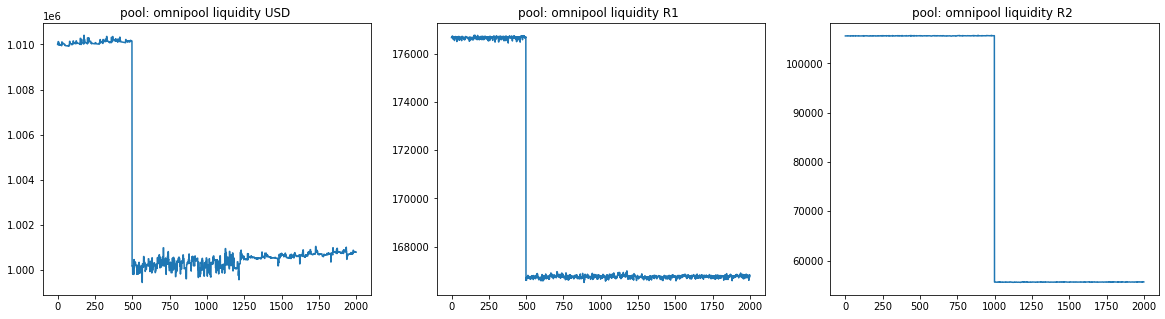

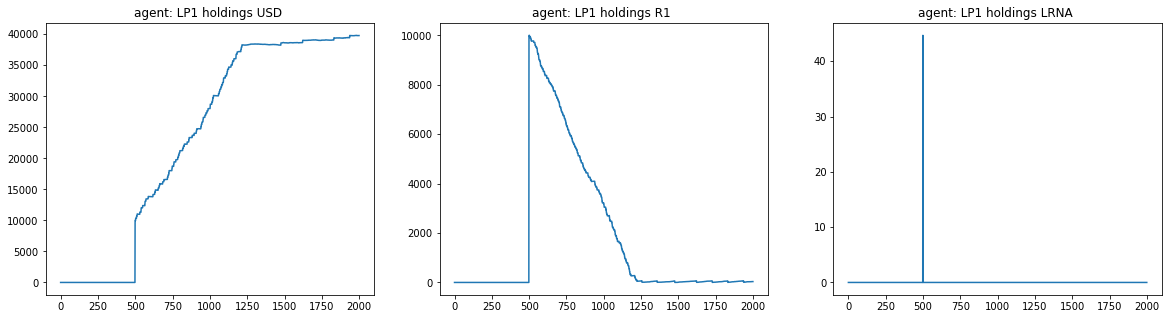

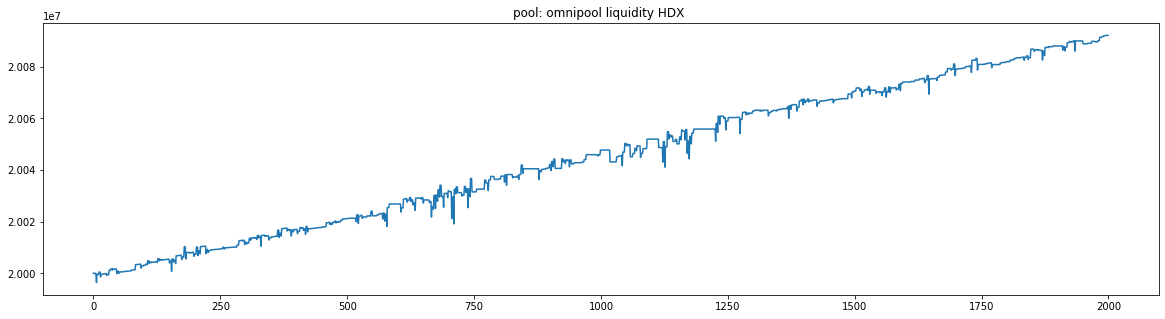

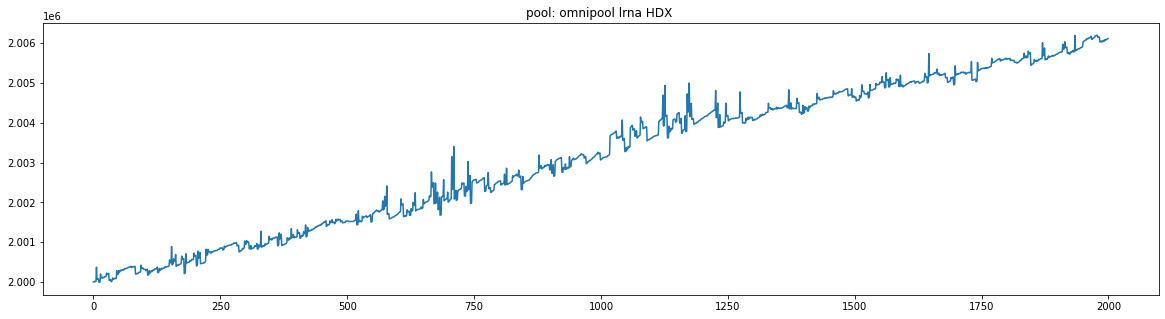

In [3]:
events = processing.postprocessing(events, optional_params=['price_of_lrna'])
pu.plot(events, pool='omnipool', prop='liquidity', key=['USD', 'R1', 'R2'])
pu.plot(events, agent='LP1', prop='holdings', key=['USD', 'R1', 'LRNA'])
pu.plot(events, pool='omnipool', prop='liquidity', key='HDX')
pu.plot(events, pool='omnipool', prop='lrna', key='HDX')

## Analysis

<AxesSubplot:title={'center':'pool: omnipool lrna_price USD '}>

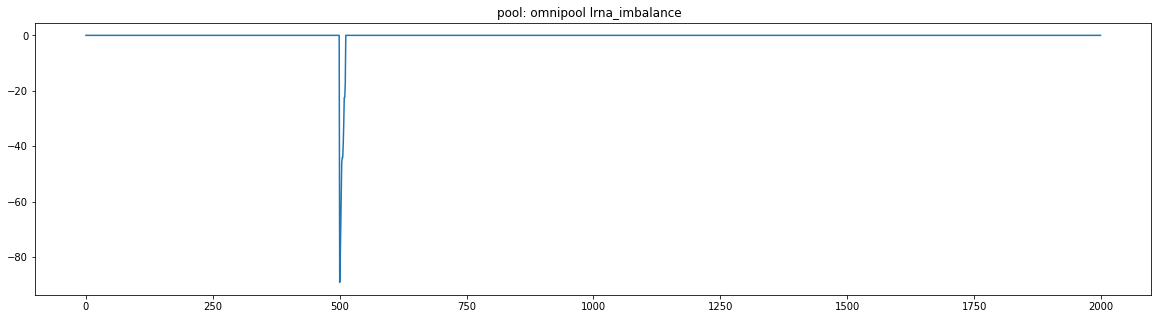

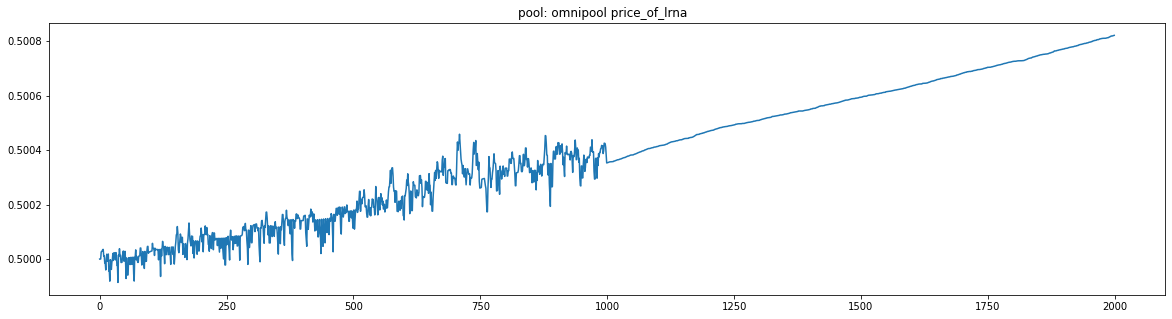

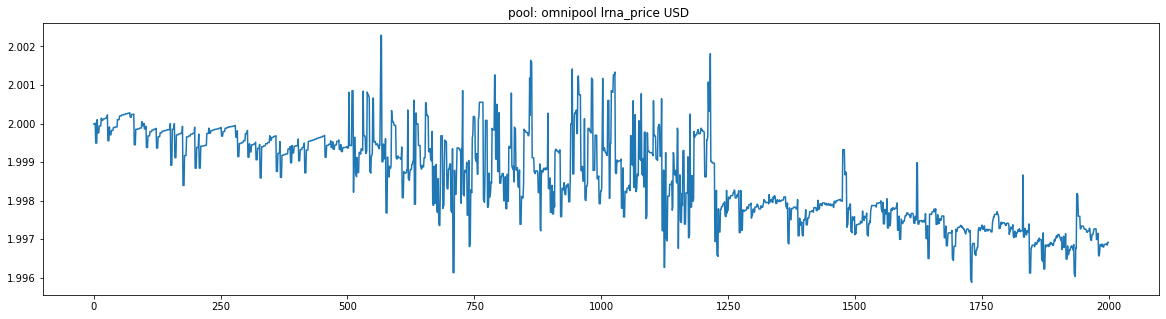

In [4]:
pu.plot(events, pool='omnipool', prop='lrna_imbalance')
pu.plot(events, pool='omnipool', prop='price_of_lrna')
pu.plot(events, pool='omnipool', prop='lrna_price', key='USD')

In [5]:
no_arbitrage_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                'HDX': {'liquidity': 2000000 * lrna_price('HDX'), 'LRNA_price': lrna_price('HDX')},
                'USD': {'liquidity': 2000000 * lrna_price('USD'), 'LRNA_price': lrna_price('USD')},
                'R1': {'liquidity': 2000000 * lrna_price('R1'), 'LRNA_price': lrna_price('R1')},
                'R2': {'liquidity': 2000000 * lrna_price('R2'), 'LRNA_price': lrna_price('R2')},
            },
            lrna_fee=0.01,
            asset_fee=0
        )
    },
    agents = {
        'Trader1': Agent(
            holdings={'R1': 1000000 * lrna_price('R1'), 'R2': 1000000 * lrna_price('R2')},
            trade_strategy=random_swaps(pool_id='omnipool', amount={'R1': 500 * lrna_price('R1'), 'R2': 500 * lrna_price('R2')})
        ), 
        'Trader2': Agent(
            holdings={'R1': 1000000 * lrna_price('R1'), 'R2': 1000000 * lrna_price('R2')},
            trade_strategy=random_swaps(pool_id='omnipool', amount={'R1': 0, 'R2': 20})
        ),
        'LP1': Agent(
            holdings={'R1': 10000, 'USD': 10000},
            trade_strategy=(
                invest_all('omnipool')
                + sell_all(pool_id='omnipool', sell_asset='LRNA', buy_asset='R1')
                + withdraw_all(when=500)
                + random_swaps(pool_id='omnipool', amount={'R1': 60, 'USD': 10, 'R2': 0})
            )
        ),
        'LP2': Agent(
            holdings={'R2': 5000},
            trade_strategy=(
                invest_all('omnipool')
                + withdraw_all(when=1000)
            )
        )
    },
    evolve_function = None,
    external_market = price_dict
)
events2 = run.run(no_arbitrage_state, time_steps=time_steps)

Starting simulation...
Execution time: 1.299 seconds.


<AxesSubplot:title={'center':'agent: LP1 holdings LRNA '}>

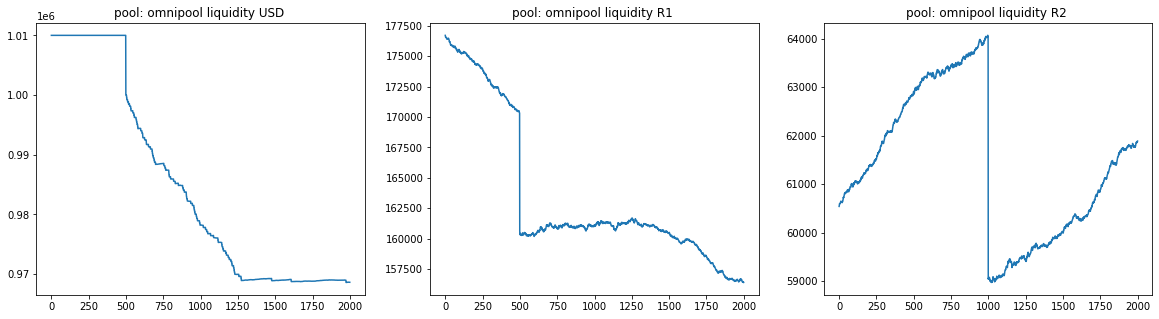

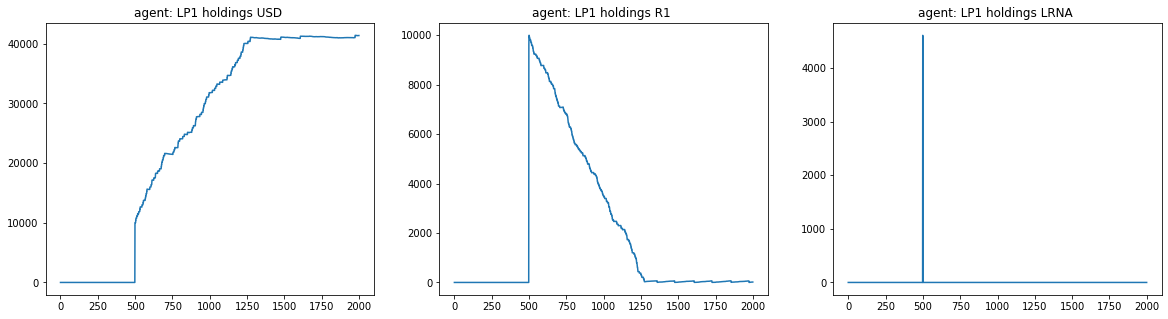

In [6]:
events2 = processing.postprocessing(events2, optional_params=['price_of_lrna'])
pu.plot(events2, pool='omnipool', prop='liquidity', key=['USD', 'R1', 'R2'])
pu.plot(events2, agent='LP1', prop='holdings', key=['USD', 'R1', 'LRNA'])

<AxesSubplot:title={'center':'pool: omnipool lrna_price USD '}>

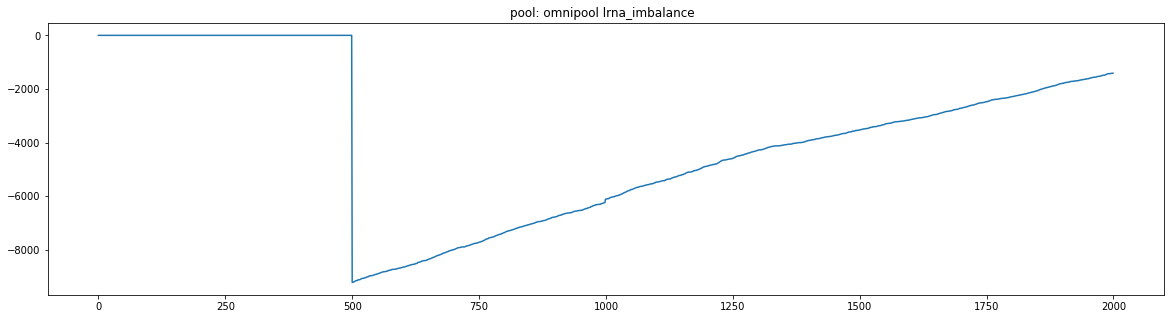

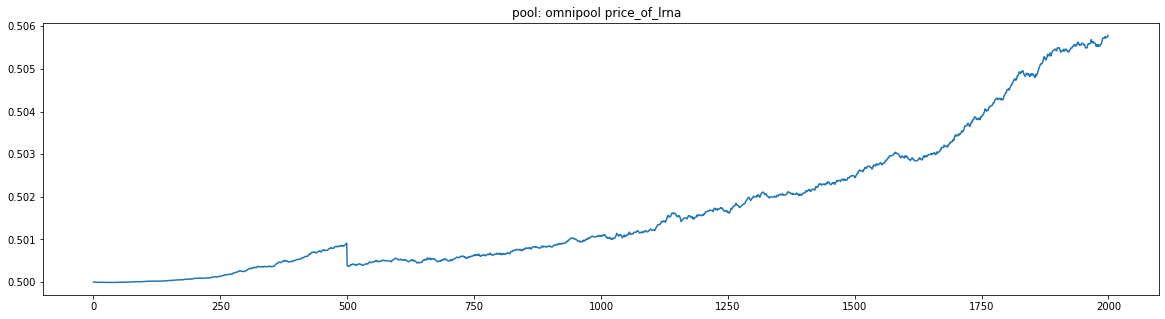

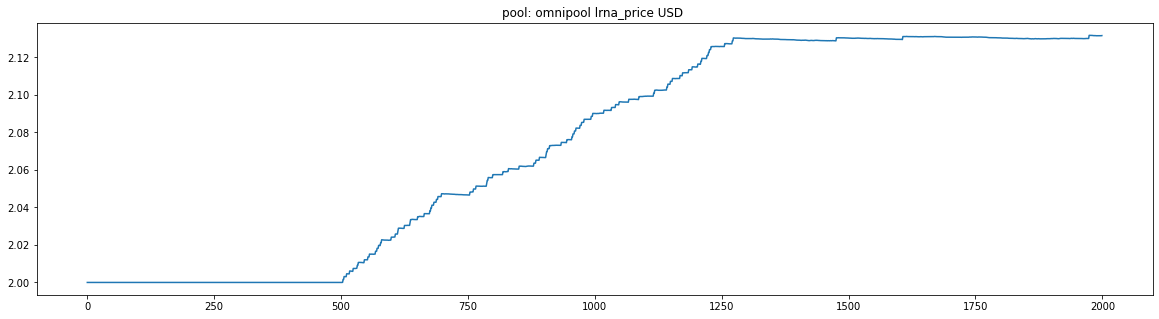

In [7]:
pu.plot(events2, pool='omnipool', prop='lrna_imbalance')
pu.plot(events2, pool='omnipool', prop='price_of_lrna')
pu.plot(events2, pool='omnipool', prop='lrna_price', key='USD')

<AxesSubplot:title={'center':'agent: LP1 holdings LRNA '}>

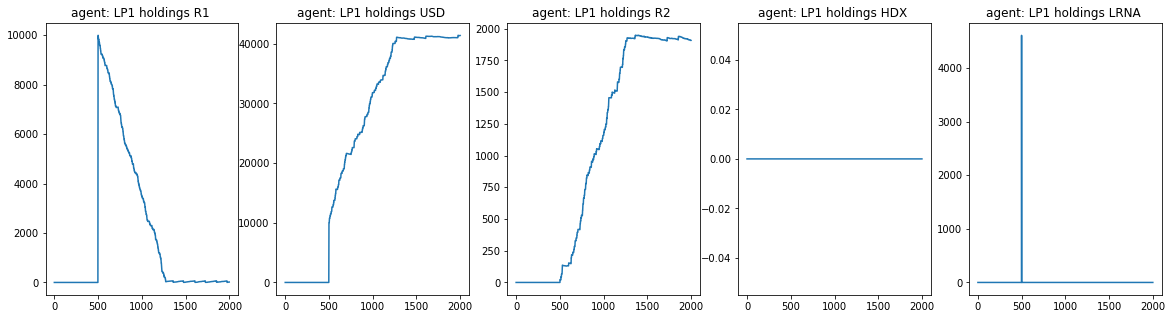

In [8]:
pu.plot(events2, agent='LP1', prop='holdings')